# Laboratorio 1 - Regresión

Este notebook tiene los siguientes elementos: 
1. Cargue de los datos.

2. Entendimiento de los datos: Describir las características más relevantes de los datos y todo el perfilamiento de datos, incluir el análisis de calidad de datos y hacer una preselección de las variables más importantes para la etapa de modelado.

3. Preparación de datos: Solucionar los problemas de calidad de datos previamente identificados que afecten el modelo a construir. Además, debe aplicar todos los proceso de preprocesamiento de datos necesarios para la construcción del modelo de regresión.

4. Modelado: Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.

5. Evaluación cuantitativa: A partir de las métricas seleccionadas para evaluar y seleccionar el mejor modelo, explicar el resultado obtenido desde el punto de vista cuantitativo. Contestar a la pregunta: ¿Su equipo recomienda utilizar en producción el modelo de regresión para estimar los tiempos? ¿Por qué? En caso de no recomendar el uso del modelo, ¿qué recomendaciones haría para continuar iterando con el objetivo de la construcción de un mejor modelo?

6. Evaluación cualitativa: Debe estar compuesta de dos partes:
- Validación de supuestos: Realizar los ajustes necesarios para que el modelo cumpla con los supuestos necesarios para la inferencia estadística con regresiones.
- Interpretación de los coeficientes: Realizar la interpretación de los coeficientes de la regresión, identificando las variables más relevantes para la estimación y cómo afectan la variable objetivo.

### Entendimiento del negocio:
El caso de estudio es de un hospital que haciendo uso de la metodología KTAS quiere solicitar un modelo que pueda pronosticar el tiempo de duración de una persona en el hospital en base a sus condiciones de llegada.
### Enfoque Analitico:
En este laboratorio vamos a hacer un modelo predictivo usando un aprendizaje supervisado y un modelo de regresión lineal para hacer uso de las condiciones de llegada de los pacientes y predecir la duración de su estancia en el hospital en minutos.


## 1. Carga de los datos

In [17]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import scipy.optimize as optimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [18]:
datos = pd.read_csv("./data/Regresión_train_data.csv")

In [19]:
datos.shape

(1000, 23)

In [20]:
datos.dtypes

Grupo                         int64
Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [21]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
98,2,1,36,3,1,headache,1,1,3,100.0,...,36.4,98.0,4,Headache,5,4,0,854,"2,00",0
853,1,2,50,3,1,epigastric pain,1,1,5,121.0,...,37.1,NaN,3,Ampulla of vater cancer,1,3,0,285,"12,13",0
837,2,2,42,3,1,Generalized abdominal pain,1,1,5,120.0,...,36.4,99.0,4,Unspecified abdominal pain,1,3,4,7900,"3,00",2
843,2,2,63,3,1,Rt. side motor weakness,1,0,#BOÞ!,160.0,...,36.4,98.0,2,Cerebrovascular accident NOS,5,2,0,321,"5,00",0
293,1,1,38,3,1,dizziness,1,0,#BOÞ!,136.0,...,37.1,NaN,3,Benign paroxysmal positional vertigo,1,3,0,83,"3,62",0


## 2. Entendimiento de los datos

Se nos proporcionaron dos CSVs, uno para entrenar el modelo y otro para probarlo, al analizar los datos dados en el csv de entrenamiento seguimos los siguientes pasos:

In [22]:
datos.describe()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,983.000000,979.000000,988.000000,985.000000,989.000000,444.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.450000,1.514000,53.892000,2.811000,1.2000,1.103000,0.562000,133.485249,79.566905,84.400810,19.450761,36.562993,97.047297,3.328000,1.610000,3.260000,0.569000,12792.480000,0.253000
std,0.497743,0.500054,19.826483,0.796186,0.4002,0.431946,0.496389,27.156136,15.174593,16.297428,2.069882,0.519699,4.761112,0.862067,1.161572,0.865534,1.587375,87721.151446,0.630387
min,1.000000,1.000000,16.000000,1.000000,1.0000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,36.000000,2.000000,1.0000,1.000000,0.000000,114.000000,70.000000,73.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,132.750000,0.000000
50%,1.000000,2.000000,56.000000,3.000000,1.0000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,270.500000,0.000000
75%,2.000000,2.000000,70.250000,3.000000,1.0000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,99.000000,4.000000,2.000000,4.000000,0.000000,620.000000,0.000000
max,2.000000,2.000000,94.000000,7.000000,2.0000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,39.800000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,2.000000


En el CSV hay datos de 1000 pacientes, con 23 caracteristicas independientes.

Se puede ver que un 75% de los valores de la variable objetivo "Duracion_Estancia_Min" estan sobre los 620 minutos (10 horas y 20 minutos), sin embargo hay datos que alcanzan hasta los 709,510 minutos (1 año y 127 días).

Al ver los atributos de cada una de las filas agrupamos las carateristicas de la sigueinte manera.

| Category |Fields|
|----------|------|
| Demografía |Sexo, Edad, Grupo|
| Accidente |Modo Llegada, Lesión, Queja, Principal|
| Signos Vitales |Estado Mental, SBP, DBP, HR, RR, BT, Saturación, Dolor|
| Diagnósticos |dolor NRS, KTAS enfermera, Diagnóstico En Urgencias, Disposición, KTAS experto, Duración_Estancia_Min, Duración_KTAS_Min, Error_Triaje|

Lo que nos dice es que una fila de los datos que tiene información de un paciente se compone de su demografia, accidente, los signos vitales y el dignostico que le dió en el ala de urgencias.
Entré las caraterisiticas mas relevantes se encuentran:
- Los signos vitales: Estado mental, presión Arterial Sistólica, Presión Arterial Diastólica, Frecuencia cardíaca, Frecuencia Respiratoria, Temperatura Corporal y Saturación de Oxígeno.
- La edad de los pacientes.
- El Triaje realizado por la enfermera y los expertos.
- El modo en el que llevan al hospital.

Se realiza un analisis de completitud en el que podemos ver que todos los datos están completos, cuentan con 1000 registros, menos los signos vitales. El mas detacado es la saturación que un 50% de los datos no cuenta con este valor. El resto de los signos vitales no supera el 20% de faltantes. Creemos que la toma de estos signos está relacionada con la gravedad del estado del paciente.

In [23]:
datos.isnull().sum() / datos.shape[0]

Grupo                       0.000
Sexo                        0.000
Edad                        0.000
Modo_Llegada                0.000
Lesion                      0.000
Queja_Principal             0.000
Estado_Mental               0.000
Dolor                       0.000
dolor_NRS                   0.000
SBP                         0.017
DBP                         0.021
HR                          0.012
RR                          0.015
BT                          0.011
Saturacion                  0.556
KTAS_enfermera              0.000
Diagnostico_En_Urgencias    0.001
Disposicion                 0.000
KTAS_experto                0.000
Grupo_De_Error              0.000
Duracion_Estancia_Min       0.000
Duracion_KTAS_Min           0.000
Error_Triaje                0.000
dtype: float64

Los datos de la variable dolor_NRS están completos, no hay nulos, pero casi el 44% de los datos está marcado con #BOÞ!.

In [24]:
datos["dolor_NRS"].value_counts()/datos.shape[0]

dolor_NRS
#BOÞ!    0.440
3        0.209
4        0.111
5        0.109
6        0.059
2        0.031
7        0.027
8        0.008
10       0.003
1        0.002
9        0.001
Name: count, dtype: float64

La Duracion_KTAS_Min se encuentra guardada como object y nó como float64. Se decide realizar este cambio para poder contininuar con el entendimiento de los datos.

In [25]:
datos["Duracion_KTAS_Min"] = datos["Duracion_KTAS_Min"].str.replace(',', '.').astype('float64')
datos["Dur_KTAS_lin"] = np.log(datos["Duracion_KTAS_Min"])

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

Para fines practicos se extrae en una lista todas las variables numericas que se pueden procesar.

In [26]:
numericas = ["Grupo", "Sexo", "Edad",  "Modo_Llegada", "Lesion", "Estado_Mental", "Dolor","KTAS_enfermera", "SBP", "DBP", "HR", "RR", "BT", "Saturacion", "Disposicion", "KTAS_experto", "Duracion_KTAS_Min", "Duracion_Estancia_Min"]

Dadao que existen una gran brecha entre la duración de la estancia, que el 75% está por debajo de 700 y después de esos se dipara, tomamos la decicion de no contar con esos datos para poder seguir con el entendimiento. Como se puede ver acontinuacion. los datos crecen de forma razonable hasta cierto punto.

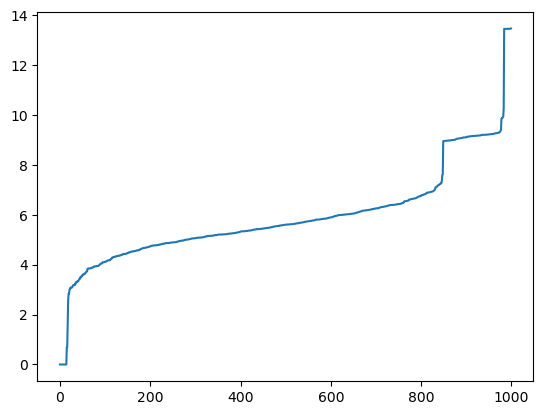

In [28]:
plt.plot(np.log(np.sort(datos["Duracion_Estancia_Min"]+1)))

<Axes: ylabel='Duracion_Estancia_Min'>

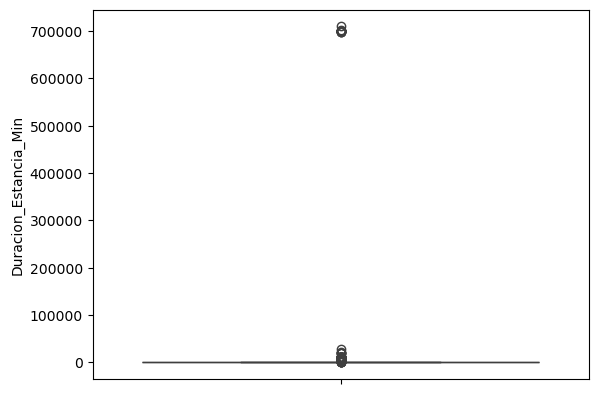

In [29]:
sns.boxplot(datos["Duracion_Estancia_Min"])

Para continuar con el entendimiento se decide tomar el percentil 0.8 de los datos, lo que equivale a todas las filas que el tiempo de su estancia sea menor a 858 minutos, lo que nos dá unos datos menos dispersos y manejables. 

(800, 24)
858.0000000000002


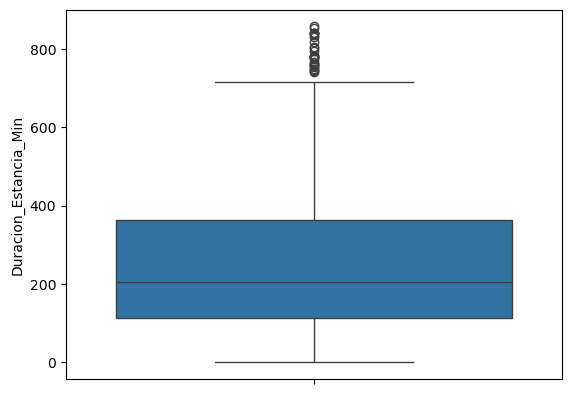

In [30]:
val = datos["Duracion_Estancia_Min"].quantile(0.8)
datos_recorte =datos[datos["Duracion_Estancia_Min"]<=val]
sns.boxplot(datos_recorte["Duracion_Estancia_Min"])
print(datos_recorte.shape)
print(val)

Realizamos una grafica scatter por cada variable numerica para tratar de ver tendencias de comportamiento de los datos

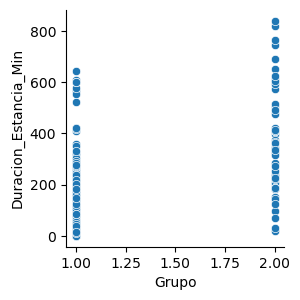

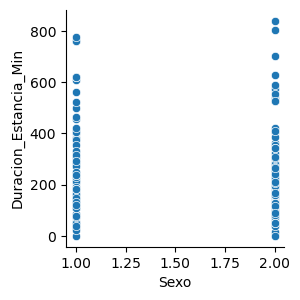

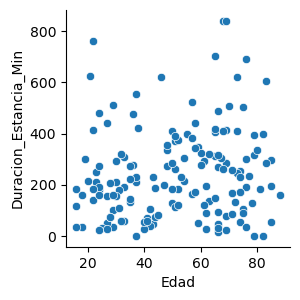

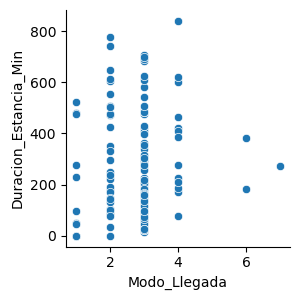

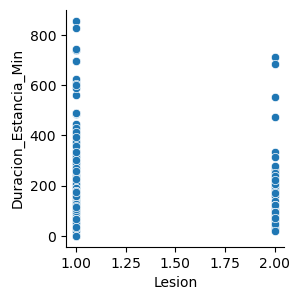

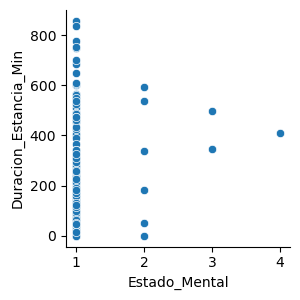

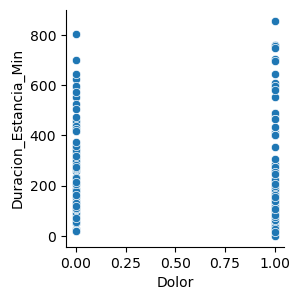

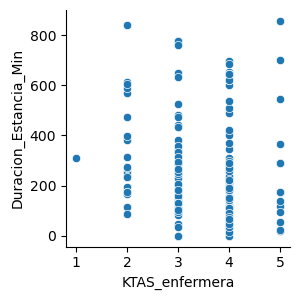

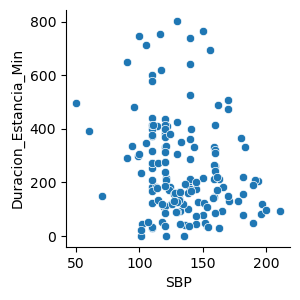

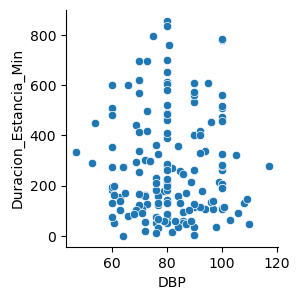

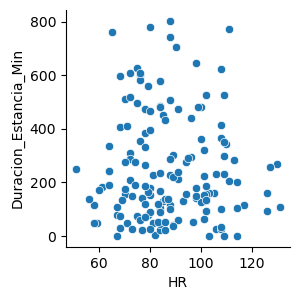

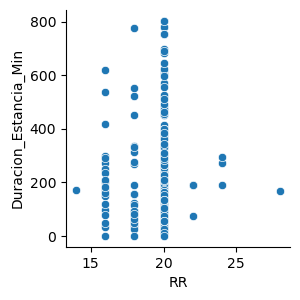

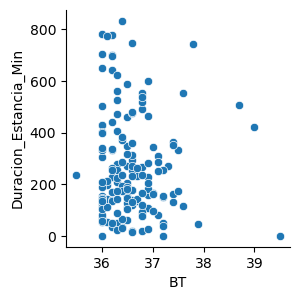

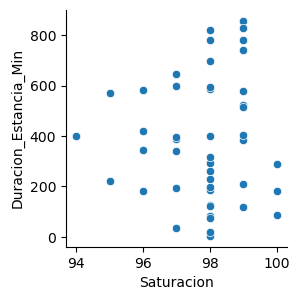

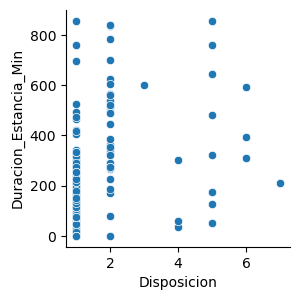

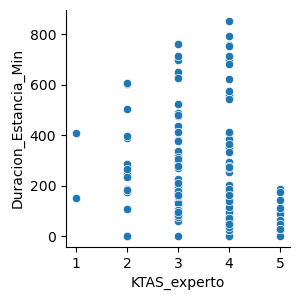

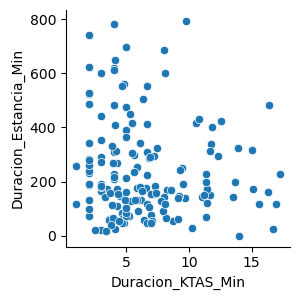

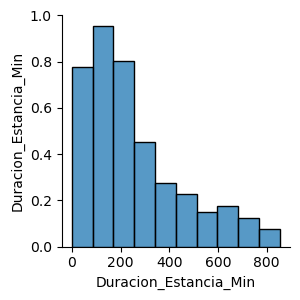

In [33]:
for variable in numericas:
    sns.pairplot(datos_recorte.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

En un mapa de calor ponemos la relación entre todas las variables para ver como se relacionan con la variable objetivo "Duración de la Estancia". 

Las variables que mas relaciones tienen son Grupo: 40%, Lesion: 16%, KTAS_experto: 24%, edad: 21%, la disposicion: 18% y la duración del KTAS: 20%. Los signos vitales son muy dispersos y podemos optar por unilos.

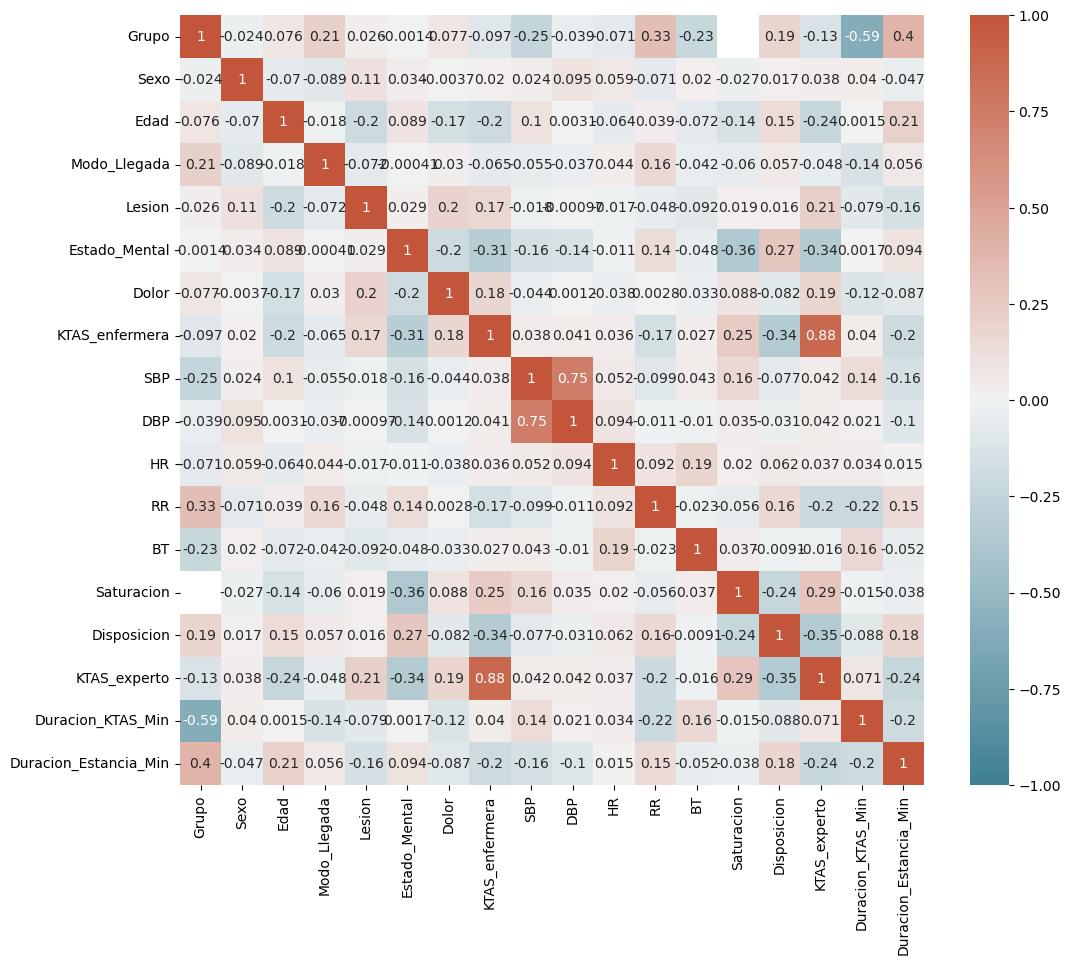

In [31]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    datos_recorte[numericas].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

Probamos con todos los datos sin el recorte del 80% y podemos ver como todas las relaciones con la variable objetivo decrecen, a excepcion del grupo, todas las variables se relacionan menos de un 1%

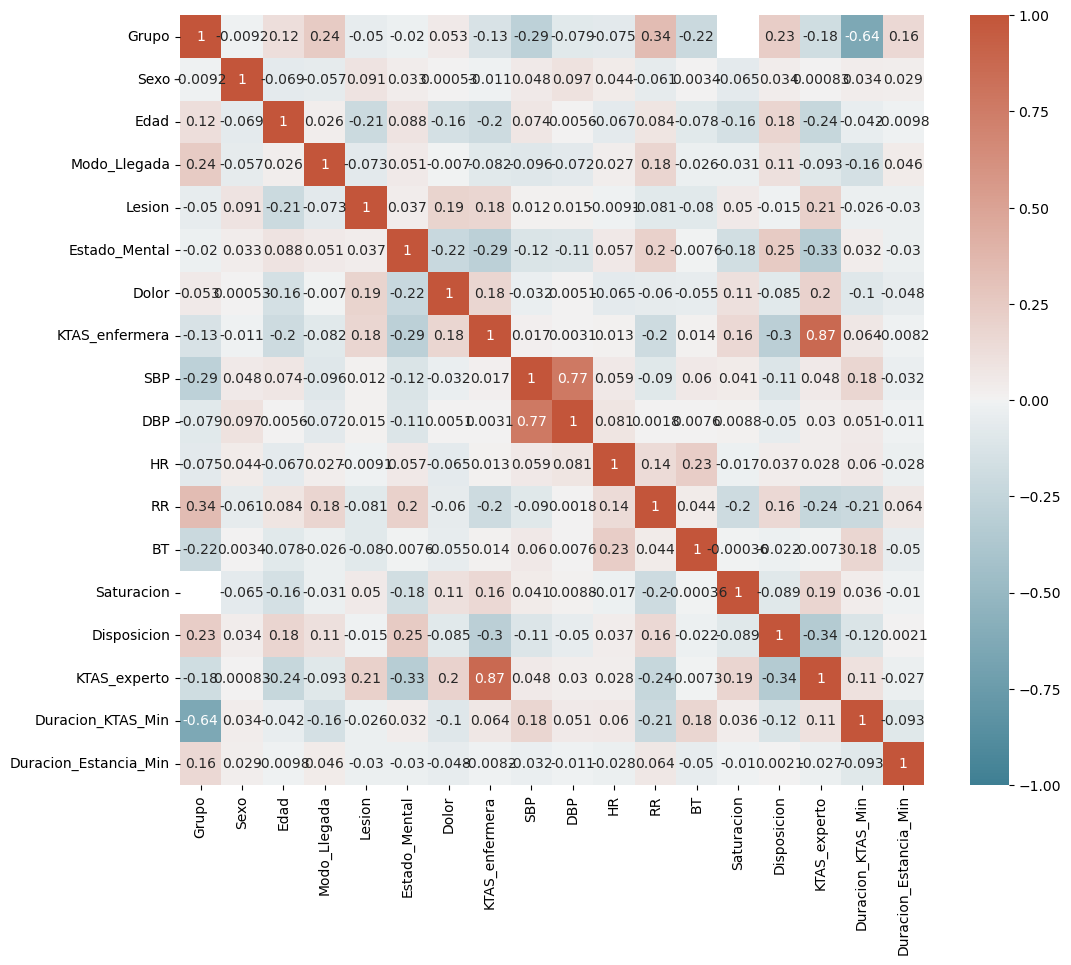

In [34]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    datos[numericas].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

En la preseleccion de los datos elegimos las variables mas relevantes con relacion a la objetivo.

In [ ]:
candidatas = ["Grupo", "Lesion","KTAS_experto","Disposicion",  "Edad", "Duracion_KTAS_Min"]


## 3. Preparación de datos

In [ ]:
candidatas = ["Grupo", "Lesion_stan","KTAS_experto_stan","EWS", "Dur_KTAS_lin"]

In [75]:
datos["KTAS_experto_stan"]=datos["KTAS_experto"].apply(lambda x: 5 if x==1 else( 4 if x==2 else(2 if x==4 else (1 if x==5 else(3)))))

In [76]:
datos["Sexo_stan"] = datos["Sexo"].apply(lambda x: 0 if x == 2 else x)
datos["Sexo_stan"].value_counts()

Sexo_stan
0    514
1    486
Name: count, dtype: int64

In [77]:
datos["Lesion_stan"]=datos["Lesion"].apply(lambda x:0 if x == 2 else x)
datos["Lesion_stan"].value_counts()

Lesion_stan
1    800
0    200
Name: count, dtype: int64

In [78]:
def calida_dolor_NRS(registro):
    if registro["dolor_NRS"] == "#BOÞ!" and registro["Dolor"] == 0:
        return 0
    elif registro["dolor_NRS"] == "#BOÞ!" and registro["Dolor"] != 0:
        return registro["dolor_NRS"]
    return int(registro["dolor_NRS"])
datos['dolor_NRS'] = datos.apply(calida_dolor_NRS, axis=1)

mean = datos[datos["dolor_NRS"] != "#BOÞ!" ]['dolor_NRS'].mean()
datos["dolor_NRS"] = datos["dolor_NRS"].apply(lambda x: round(mean) if x == "#BOÞ!" else x)
datos["dolor_NRS"].value_counts()


dolor_NRS
0     438
3     209
4     111
5     109
6      59
2      33
7      27
8       8
10      3
1       2
9       1
Name: count, dtype: int64

In [80]:
def calcularEWS(registro):
    total = 0
    
    # Frecuencia respiratoria (RR)
    if registro['RR'] <= 8:
        total += 2
    elif 9 <= registro['RR'] <= 14:
        total += 0
    elif 15 <= registro['RR'] <= 20:
        total += 1
    elif 21 <= registro['RR'] <= 29:
        total += 2
    elif registro['RR'] >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro['SBP'] <= 70:
        total += 3
    elif 71 <= registro['SBP'] <= 80:
        total += 2
    elif 81 <= registro['SBP'] <= 100:
        total += 1
    elif 101 <= registro['SBP'] <= 199:
        total += 0
    elif registro['SBP'] >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro['HR'] <= 40:
        total += 2
    elif 41 <= registro['HR'] <= 50:
        total += 1
    elif 51 <= registro['HR'] <= 100:
        total += 0
    elif 101 <= registro['HR'] <= 110:
        total += 1
    elif 111 <= registro['HR'] <= 129:
        total += 2
    elif registro['HR'] >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro['BT'] < 35.0:
        total += 2
    elif 35.0 <= registro['BT'] <= 38.4:
        total += 0
    elif 38.5 <= registro['BT']:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro['Saturacion'] <= 91:
        total += 3
    elif 92 <= registro['Saturacion'] <= 93:
        total += 2
    elif 94 <= registro['Saturacion'] <= 95:
        total += 1

    # Nivel de conciencia
    if registro['Estado_Mental'] == 1:
        total += 0
    elif registro['Estado_Mental'] == 2:
        total += 1
    elif registro['Estado_Mental'] == 3:
        total += 2
    elif registro['Estado_Mental'] == 4:
        total += 3
    return total

datos['EWS'] = datos.apply(calcularEWS, axis=1)
datos.head()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,KTAS_experto_stan,Sexo_stan,Lesion_stan,EWS
0,2,2,49,2,1,ant. chest pain,1,1,2,150.0,...,2,2,0,1591,"2,00",0,4,0,1,1
1,2,2,30,4,1,headache,1,1,4,140.0,...,7,3,0,211,"3,00",0,3,0,1,1
2,2,1,61,3,2,ant. chest pain,1,1,3,100.0,...,1,4,0,119,"2,00",0,2,1,0,2
3,2,2,61,3,1,headache,1,1,4,120.0,...,1,3,4,414,"2,00",2,3,0,1,1
4,1,2,67,3,1,fever & chill,1,0,0,143.0,...,1,2,1,267,"3,60",2,4,0,1,4


## 3. Preparación de datos

In [85]:
datos["Modo_Llegada"] = datos["Modo_Llegada"].apply(lambda x: 1 if x == 1 else (2 if x == 2 or x ==4 else (3 if x == 3 else 4)))


### 3.1. Relacionado con la calidad de los datos

In [97]:
val = datos["Duracion_Estancia_Min"].quantile(0.75)
datos=datos[datos["Duracion_Estancia_Min"]<=val]
print(val)
datos.shape


620.0


(751, 28)

In [98]:
# Se eliminan los registros totalmente duplicados
datos = datos.dropna(subset=["Duracion_Estancia_Min"]+candidatas)

In [99]:
datos.shape
total_rows = datos.shape[0]
total_rows

751

In [100]:
datos[["Duracion_Estancia_Min"]+candidatas].isnull().sum() / datos.shape[0]

Duracion_Estancia_Min    0.0
Grupo                    0.0
Lesion_stan              0.0
KTAS_experto_stan        0.0
EWS                      0.0
Dur_KTAS_lin             0.0
dtype: float64

In [101]:
datos[datos[["Duracion_Estancia_Min"]+candidatas] == '#BOÞ!'][["Duracion_Estancia_Min"]+candidatas].count()/ datos.shape[0]

Duracion_Estancia_Min    0.0
Grupo                    0.0
Lesion_stan              0.0
KTAS_experto_stan        0.0
EWS                      0.0
Dur_KTAS_lin             0.0
dtype: float64

In [102]:
datos.loc[datos.duplicated(subset=candidatas, keep=False)].head(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,KTAS_experto_stan,Sexo_stan,Lesion_stan,EWS,Dur_KTAS_lin
1,2,2,30,2,1,headache,1,1,4,140.0,...,3,0,211,3.0,0,3,0,1,1,1.098612
2,2,1,61,3,2,ant. chest pain,1,1,3,100.0,...,4,0,119,2.0,0,2,1,0,2,0.693147
3,2,2,61,3,1,headache,1,1,4,120.0,...,3,4,414,2.0,2,3,0,1,1,0.693147
9,2,2,27,2,1,LLQ pain,1,1,3,130.0,...,4,0,493,2.0,0,2,0,1,1,0.693147
12,2,2,69,3,1,dyspnea,1,0,0,100.0,...,3,0,415,4.0,0,3,0,1,2,1.386294


In [103]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas, keep=False)].shape[0]
duplicated_rows

295

In [104]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 39.2810%


In [105]:
datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].tail(4)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,KTAS_experto_stan,Sexo_stan,Lesion_stan,EWS,Dur_KTAS_lin
996,1,1,27,3,1,Suicidal Attempt,1,0,0,110.0,...,3,0,442,7.42,0,3,1,1,1,2.004179
997,1,2,54,2,1,"pain, chest",1,1,6,159.0,...,2,0,214,4.95,0,4,0,1,1,1.599388
998,1,1,19,3,1,eye discomfort,1,0,0,132.0,...,4,0,50,3.45,0,2,1,1,1,1.238374
999,1,2,29,3,1,"pain, abdominal",1,1,6,137.0,...,3,0,116,5.97,0,3,0,1,1,1.786747


In [106]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].shape[0]
duplicated_rows

63

In [107]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 8.3888%


In [108]:
datos.drop_duplicates(subset=candidatas, inplace=True)
datos.drop_duplicates(subset=candidatas+["Duracion_Estancia_Min"], inplace=True)

In [109]:
datos.shape

(543, 28)

Train: 142.37727523589766
Test: 132.14368275061634


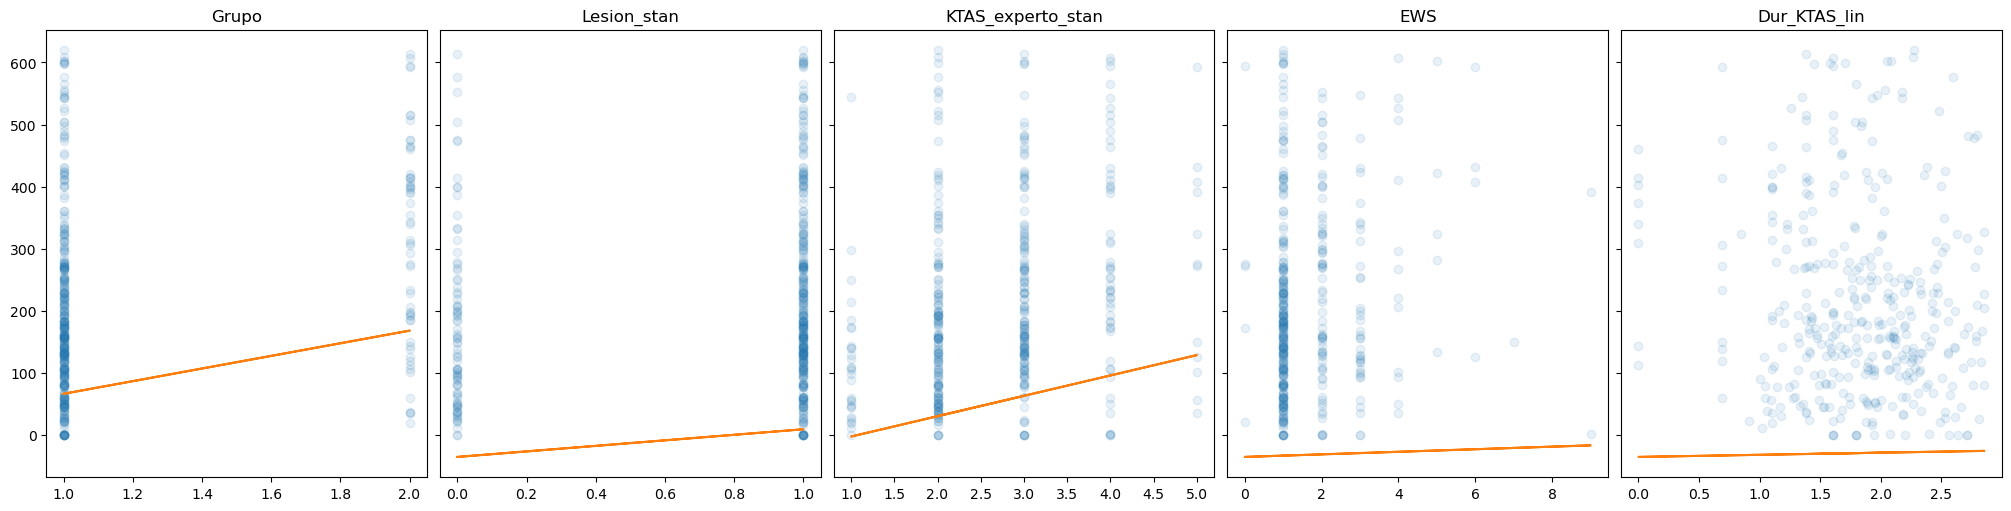

In [110]:
X_train, X_test, y_train, y_test = train_test_split(datos[candidatas], datos["Duracion_Estancia_Min"], test_size=0.3, random_state=1)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
regression = LinearRegression()
regression.fit(X_train, y_train)
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})
f, axs = plt.subplots(1, len(candidatas), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(candidatas)):
    col = candidatas[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))


In [111]:
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})

,columns,coef
0,Grupo,101.675944
1,Lesion_stan,44.533993
2,KTAS_experto_stan,32.802483
3,EWS,2.067761
4,Dur_KTAS_lin,3.414286


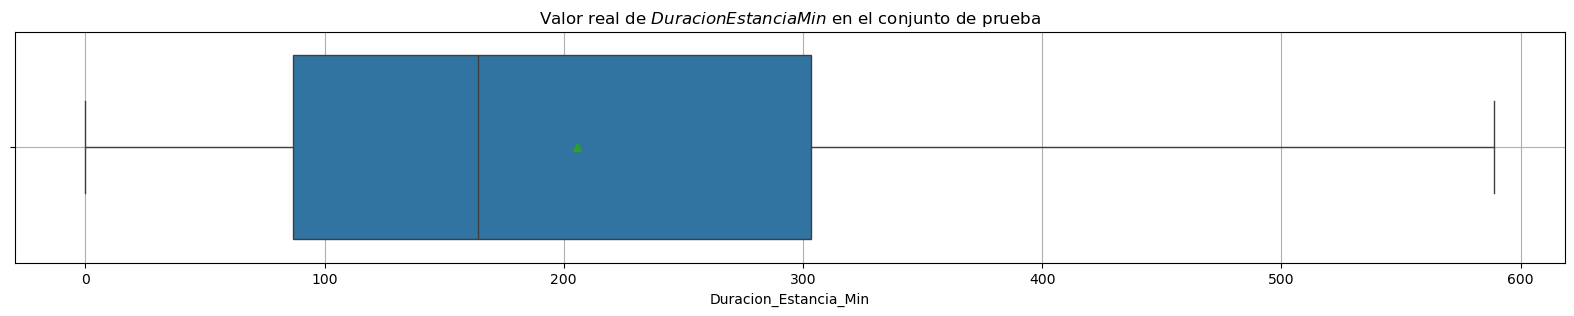

In [112]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Duracion Estancia Min}$ en el conjunto de prueba")
plt.grid()
plt.show()

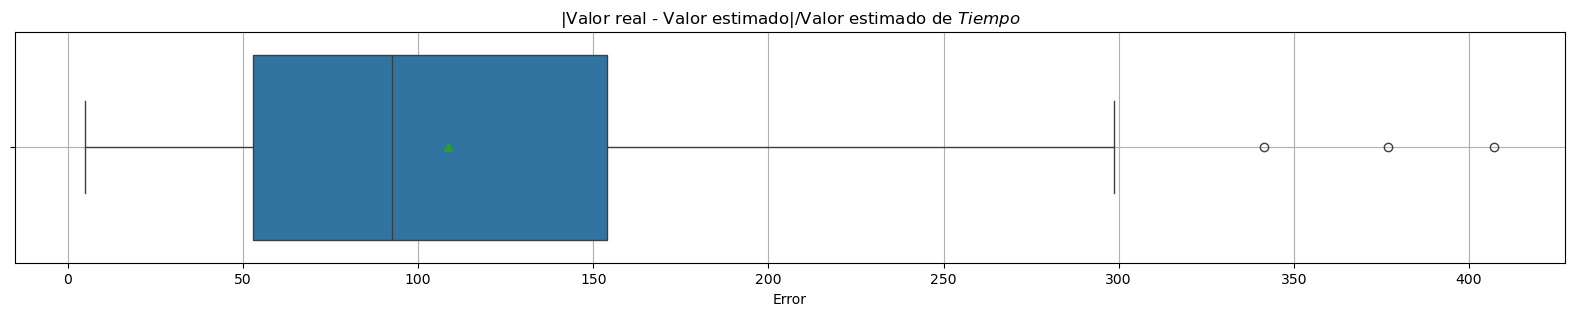

In [113]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado|/Valor estimado de $\t{Tiempo}$")
plt.xlabel("Error")
plt.grid()
plt.show()